# Analyzing the ACLED data with Spark

ACLED (Armed Conflict Location and Event Data Project) is designed for disaggregated conflict analysis and crisis mapping. This dataset codes the dates and locations of all reported political violence and protest events in over 60 developing countries in Africa and Asia. Political violence and protest includes events that occur within civil wars and periods of instability, public protest and regime breakdown. The project covers all African countries from 1997 to the present, and South and South-East Asia in real-time. For more information visit the [ACLED website](http://www.acleddata.com/).

This work is solely based on the african data, covering a time lapse between the years 1997 and 2015. The purpose of the work is to extract relevant information from the dataset using the basic features of Spark.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import date_format, col, udf, lit


Create the Spark and SQL contexts.

In [2]:
sc = pyspark.SparkContext('local[*]')
sqlCtx = SQLContext(sc)

Load the file with the data. This version contains less columns than the original dataset, for I removed unnecesary for this analysis, like coordinates, notes and source.

In [3]:
africa_rdd = sc.textFile('africa2.csv')

For every line, split the columns and map the lines with the Row. Then convert the RDD into a DataFrame.

In [4]:
Event = Row('event_date', 'year', 'event_type', 'actor1', 'inter1', 'actor2', 'inter2', 'country', 'location', 
            'fatalities')

def getEvent(line):
    cells = line.split(',')
    return Event(*cells)

africa = africa_rdd.map(getEvent)
africa_df = africa.toDF()

Convert the columns into the proper type and remove NAs. The resulting data frame contains the following attributes:
- event_date: date of the event with the format dd/mm/yyyy
- year: the year in which the event took place
- event_type: a description of the type of the event that could be one of the following values
    * Battle-No change of territory
    * Battle-Non-state actor overtakes territory
    * Battle-Government regains territory
    * Headquarters or base established
    * Strategic Development
    * Riots/Protests
    * Violence against civilians
    * Non-violent transfer of territory
    * Remote violence
- actor1: actor involved in the conflict
- inter1: type of actor1
- actor2: actor involved in the conflict
- inter2: type of actor2
- country: the country in which the event took place
- location: the location in which the event took place
- fatalities: the numer or estimate of fatalities

In [5]:
africa_df = africa_df.select('*', africa_df.fatalities.cast('integer').alias('fatalities_i'), 
                             africa_df.year.cast('integer').alias('year_i'))
africa_df = africa_df.dropna()
africa_df = africa_df.select('*', date_format(africa_df.event_date,'\"%d/%m/%Y\"').alias('date'))

In [6]:
africa_df.printSchema()

root
 |-- event_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- actor1: string (nullable = true)
 |-- inter1: string (nullable = true)
 |-- actor2: string (nullable = true)
 |-- inter2: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- fatalities: string (nullable = true)
 |-- fatalities_i: integer (nullable = true)
 |-- year_i: integer (nullable = true)
 |-- date: string (nullable = true)



## Exploratory analysis

This section shows an exploratory analysis to the dataset. First I register a temporary table with the dataframe created in the previous section.

In [7]:
africa_df.registerTempTable("africa")

This query gets the top 10 of countries according to the number of conflicts. Somalia shows up as the most troubled country, probably a reflection of the ongoing [Somali Civil War](https://en.wikipedia.org/wiki/Somali_Civil_War).

In [8]:
sqlCtx.sql('SELECT country, COUNT(*) AS count \
           FROM africa GROUP BY country ORDER BY count \
           DESC LIMIT 10').toPandas()

,country,count
0,"""Somalia""",17454
1,"""Democratic Republic of Congo""",9825
2,"""Nigeria""",8541
3,"""Sudan""",8227
4,"""South Africa""",7421
5,"""Egypt""",6917
6,"""Zimbabwe""",5363
7,"""Kenya""",5041
8,"""Uganda""",4611
9,"""Sierra Leone""",4598


Every event has an type that describes the nature of the conflict. The following query counts the number of incidences of every type of event, showing that the most common types are battles without change of territory and violence against civilians.

This query was created using the API, and hereinafter all the queries are created this way.

In [9]:
africa_df.select("country", "event_type", "year")\
        .groupBy('event_type')\
        .agg({"event_type":"count"})\
        .orderBy('count(event_type)',ascending=False)\
        .limit(10)\
        .toPandas()

,event_type,count(event_type)
0,"""Battle-No change of territory""",34137
1,"""Violence against civilians""",33393
2,"""Riots/Protests""",29640
3,"""Strategic development""",7217
4,"""Remote violence""",6812
5,"""Non-violent transfer of territory""",2150
6,"""Battle-Government regains territory""",1891
7,"""Battle-Non-state actor overtakes territory""",1803
8,"""Headquarters or base established""",733


The following query shows the top 10 of actors of factions that take part on conflicts. Armed groups and military forces shows up on the top 10, but also protesters and rioters.

In [10]:
africa_df.select('actor1','inter1')\
            .groupBy('actor1')\
            .agg({'actor1':'count'})\
            .orderBy('count(actor1)', ascending=False)\
            .limit(10)\
            .toPandas()

,actor1,count(actor1)
0,"""Unidentified Armed Group (Somalia)""",4543
1,"""Protesters (South Africa)""",3428
2,"""Military Forces of Somalia (2012-)""",3004
3,"""Rioters (South Africa)""",2487
4,"""ZANU-PF: Zimbabwe African National Union-Patr...",2460
5,"""Protesters (Egypt)""",2449
6,"""Al Shabaab""",2385
7,"""Military Forces of Angola (1975-)""",2347
8,"""Military Forces of Democratic Republic of Con...",2084
9,"""LRA: Lord's Resistance Army""",1927


Next, I show the top 10 of most conflicting cities according to the number of events registered per location. For that, I create a dataframe with the registry of cities and countries they belong to (first query). The following query gets the locations aggregated by the count of events, resulting in a second dataframe. Finally, I join both datasets by the 'location' column. The result shows the top 10 of conflicting locations with the country.

In [11]:
locations_df = sqlCtx.sql('SELECT country, location FROM africa GROUP BY location, country')

top_conflicting_locations = africa_df.select('location')\
                                    .groupBy('location')\
                                    .agg({'location':'count'})\
                                    .orderBy('count(location)', ascending=False)\
                                    .limit(10)

joined_df = top_conflicting_locations.join(locations_df, top_conflicting_locations.location == locations_df.location, 'inner')\
                                    .orderBy('count(location)', ascending=False)\
                                    .drop(top_conflicting_locations.location)
joined_df.toPandas()

,count(location),country,location
0,1218,"""Somalia""","""Mogadishu"""
1,1080,"""Zimbabwe""","""Harare"""
2,892,"""Central African Republic""","""Bangui"""
3,730,"""Somalia""","""Hodan"""
4,696,"""Libya""","""Tripoli"""
5,678,"""Ivory Coast""","""Abidjan"""
6,676,"""South Africa""","""Cape Town"""
7,676,"""Egypt""","""Cairo"""
8,652,"""Libya""","""Benghazi"""
9,640,"""Somalia""","""Kismayo"""


## Libya at war

In the past 5 years Libya has faced several armed conflicts, and in this analysis I show the evidence present in the data. I start by creating a dataframe with only events registered in Libya.

In [12]:
libya_df = africa_df.select('*')\
                    .where("country='\"Libya\"'")

Aggregating this dataset by the number of conflicts per year shows a clear change between the years 2010 and 2011. In 2011 the [First Libyan Civil War](https://en.wikipedia.org/wiki/Libyan_civil_war_(2011), leading to a phase of turmoil known as the [Post-civil war violence](https://en.wikipedia.org/wiki/Factional_violence_in_Libya_(2011%E2%80%9314) and the still ongoing [Second Libyan Civil War](https://en.wikipedia.org/wiki/Libyan_civil_war_(2014%E2%80%93present). This events increased the number of conflicts dramatically, as can be seen in the plot below.

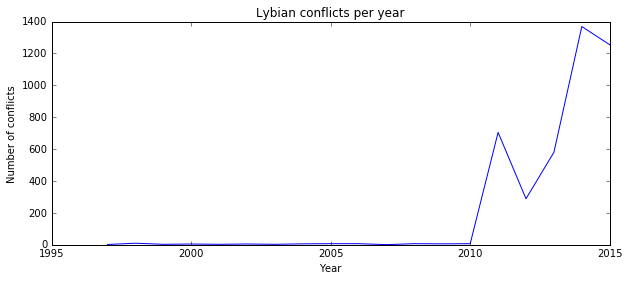

In [13]:
df = libya_df.groupBy('year')\
                .agg({'year':'count'})\
                .toPandas()
        
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(df['year'],df['count(year)'])
ax.set_title('Lybian conflicts per year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of conflicts')

The next pieces of code is an analysis of the conflicts in 2015. The query aggregates the data per day and counts the number of fatalities. The total of fatalities in 2015 was of 2705, and the most deadly day was January 3, with a death toll of 101 due to 7 conflicts.

In [14]:
libya_fatalities_per_day = libya_df.select('year','event_date','fatalities_i')\
                                    .where("year=2015")\
                                    .groupBy('event_date')\
                                    .agg({'fatalities_i':'sum','event_date':'count'})\
                                    .orderBy('sum(fatalities_i)',ascending=False)

In [15]:
df = libya_fatalities_per_day.toPandas() 
df['event_date'] = np.array([datetime.strptime(x, '\"%d/%m/%Y\"') for x in df['event_date']])
df['sum(fatalities_i)'] = [int(x) for x in df['sum(fatalities_i)']]
df = df.sort(['event_date'],ascending=[1])

fatalities_2015 = sum(df['sum(fatalities_i)'])

print('Fatalities in 2015: ' + str(fatalities_2015))
print('Most deadly day: ', libya_fatalities_per_day.first())

Fatalities in 2015: 2705
Most deadly day:  Row(event_date='"03/01/2015"', sum(fatalities_i)=101, count(event_date)=7)


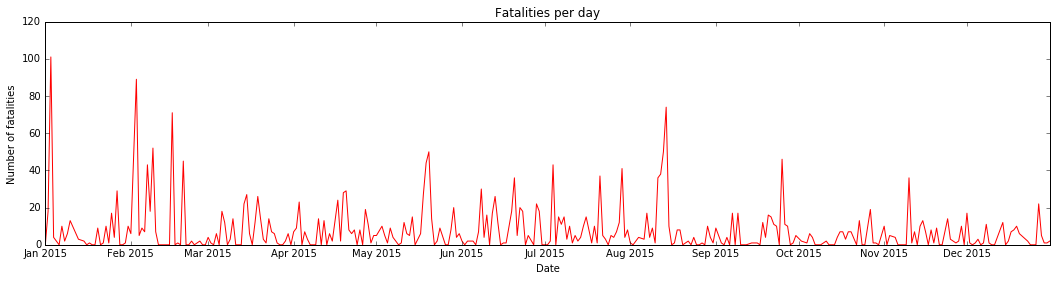

In [16]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.plot_date(df['event_date'],df['sum(fatalities_i)'], fmt='r-', label = "Number of fatalities")
ax.set_title('Fatalities per day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of fatalities')